In [31]:
import os
import numpy as np
import pandas as pd
import cv2
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.utils import Sequence

In [32]:
# === RUTAS ===
cracked_dir = r'C:\Users\marco\AndroidStudioProjects\TFG\TFG-App-IA-IncidenciasViales\ModeloIA\datasets\cracks'
holes_dir = r'C:\Users\marco\AndroidStudioProjects\TFG\TFG-App-IA-IncidenciasViales\ModeloIA\datasets\holes\images'
postesCaidos_dir =r'C:\Users\marco\AndroidStudioProjects\TFG\TFG-App-IA-IncidenciasViales\ModeloIA\datasets\PostesCaidos'
sinIncidencia_dir = r'C:\Users\marco\AndroidStudioProjects\TFG\TFG-App-IA-IncidenciasViales\ModeloIA\datasets\sinIncidencia'


In [33]:

# Crear listas con rutas y etiquetas
image_paths = []
labels = []

for f in os.listdir(cracked_dir):
    if f.lower().endswith(('.jpg', '.jpeg', '.png')):
        image_paths.append(os.path.join(cracked_dir, f))
        labels.append(0)  # Grieta

for f in os.listdir(holes_dir):
    if f.lower().endswith(('.jpg', '.jpeg', '.png')):
        image_paths.append(os.path.join(holes_dir, f))
        labels.append(1)  # Agujero

for f in os.listdir(postesCaidos_dir):
    if f.lower().endswith(('.jpg', '.jpeg', '.png')):
        image_paths.append(os.path.join(postesCaidos_dir, f))
        labels.append(2)  # Postes Caídos

for f in os.listdir(sinIncidencia_dir):
    if f.lower().endswith(('.jpg', '.jpeg', '.png')):
        image_paths.append(os.path.join(sinIncidencia_dir, f))
        labels.append(3)  # Sin incidencia

print(f"Total imágenes encontradas: {len(image_paths)}")

Total imágenes encontradas: 67288


In [34]:
# Crear DataFrame con rutas y etiquetas
df = pd.DataFrame({'filename': image_paths, 'label': labels})

# División en entrenamiento y validación
df_train, df_val = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)


In [42]:
def cargar_y_preprocesar_cv2(file_path):
    img = cv2.imread(file_path)
    
    if img is None:
        try:
            img_pil = Image.open(file_path).convert('RGB')
            img = np.array(img_pil)
            img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        except Exception as e:
            raise ValueError(f"No se pudo cargar la imagen: {file_path}") from e

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img, (224, 224))
    img_resized = img_resized.astype(np.float32)

    # Usa el mismo preprocesamiento que haces en Android (MobileNetV2)
    img_preproc = preprocess_input(img_resized)
    return img_preproc


In [43]:
# Generador personalizado para cargar datos
class DataGenerator(Sequence):
    def __init__(self, df, batch_size=32, shuffle=True):
        self.df = df.reset_index(drop=True)
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(self.df))
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.df) / self.batch_size))

    def __getitem__(self, index):
        batch_indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        batch_df = self.df.loc[batch_indexes]

        images = []
        labels = []

        for _, row in batch_df.iterrows():
            img = cargar_y_preprocesar_cv2(row['filename'])
            images.append(img)
            labels.append(row['label'])

        return np.array(images), np.array(labels)

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)


In [44]:
# Crear generadores para entrenamiento y validación
train_generator = DataGenerator(df_train, batch_size=32)
val_generator = DataGenerator(df_val, batch_size=32, shuffle=False)

# Calcular pesos de clase para balancear el entrenamiento
class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(df_train['label']),
    y=df_train['label']
)
class_weights = dict(enumerate(class_weights_array))

# Modelo MobileNetV2 con clasificación personalizada
base_model = MobileNetV2(weights='imagenet', include_top=False, pooling='avg')
x = base_model.output
output = Dense(4, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=output)

# Fine-tuning: entrenar últimas 50 capas
for layer in base_model.layers:
    layer.trainable = False
for layer in base_model.layers[-50:]:
    layer.trainable = True

# Compilación del modelo
model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Callback para early stopping
early_stop = EarlyStopping(patience=5, restore_best_weights=True)

# Entrenamiento
model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,
    callbacks=[early_stop],
    class_weight=class_weights,
    verbose=2
)

C:\Users\marco\AppData\Local\Temp\ipykernel_3288\1757599685.py:14: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, pooling='avg')
c:\Users\marco\AndroidStudioProjects\TFG\TFG-App-IA-IncidenciasViales\tf_env\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30


c:\Users\marco\AndroidStudioProjects\TFG\TFG-App-IA-IncidenciasViales\tf_env\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1683/1683 - 1429s - 849ms/step - accuracy: 0.9190 - loss: 0.2187 - val_accuracy: 0.9801 - val_loss: 0.0682
Epoch 2/30
1683/1683 - 1508s - 896ms/step - accuracy: 0.9832 - loss: 0.0503 - val_accuracy: 0.9860 - val_loss: 0.0416
Epoch 3/30
1683/1683 - 1509s - 897ms/step - accuracy: 0.9907 - loss: 0.0283 - val_accuracy: 0.9935 - val_loss: 0.0192
Epoch 4/30
1683/1683 - 1515s - 900ms/step - accuracy: 0.9937 - loss: 0.0192 - val_accuracy: 0.9936 - val_loss: 0.0199
Epoch 5/30
1683/1683 - 1514s - 900ms/step - accuracy: 0.9956 - loss: 0.0129 - val_accuracy: 0.9950 - val_loss: 0.0157
Epoch 6/30
1683/1683 - 1508s - 896ms/step - accuracy: 0.9969 - loss: 0.0104 - val_accuracy: 0.9967 - val_loss: 0.0115
Epoch 7/30
1683/1683 - 1509s - 896ms/step - accuracy: 0.9976 - loss: 0.0074 - val_accuracy: 0.9955 - val_loss: 0.0152
Epoch 8/30
1683/1683 - 1503s - 893ms/step - accuracy: 0.9984 - loss: 0.0055 - val_accuracy: 0.9969 - val_loss: 0.0123
Epoch 9/30
1683/1683 - 1527s - 907ms/step - accuracy: 0.9985 - loss

In [45]:
from sklearn.metrics import classification_report
import numpy as np

# Obtener predicciones del modelo
y_pred_probs = model.predict(val_generator, verbose=1)
y_pred_labels = np.argmax(y_pred_probs, axis=1)

# Obtener etiquetas verdaderas directamente del dataframe
y_true = df_val['label'].values  # O val_generator.df['label'].values

# Reporte de clasificación
print(classification_report(y_true, y_pred_labels, digits=4))


421/421 ━━━━━━━━━━━━━━━━━━━━ 203s 479ms/step
              precision    recall  f1-score   support

           0     0.9995    0.9998    0.9996      4166
           1     0.9930    0.9953    0.9941      2548
           2     0.9966    0.9983    0.9974      1170
           3     0.9978    0.9962    0.9970      5574

    accuracy                         0.9973     13458
   macro avg     0.9967    0.9974    0.9971     13458
weighted avg     0.9973    0.9973    0.9973     13458



In [29]:

import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize
import numpy as np
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

def predecir_imagen(file_path):
    img = imread(file_path)
    img_resized = resize(img, output_shape=(224, 224), preserve_range=True)
    img_preprocessed = preprocess_input(img_resized.astype(np.float32))
    img_batch = np.expand_dims(img_preprocessed, axis=0)

    pred = model.predict(img_batch)
    clase = np.argmax(pred)
    confianza = pred[0][clase] * 100

    etiquetas = ['Grieta', 'Agujero', 'Poste caído', 'Sin incidencia']
    print(f"Predicción: {etiquetas[clase]} ({confianza:.2f}%)")

    plt.imshow(img)
    plt.title(f"{etiquetas[clase]} ({confianza:.1f}%)")
    plt.axis('off')
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Predicción: Agujero (100.00%)


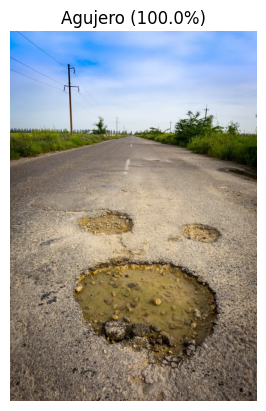

In [46]:
predecir_imagen(r'C:\Users\marco\AndroidStudioProjects\TFG\TFG-App-IA-IncidenciasViales\ModeloIA\IMG\agujero.webp')

In [47]:
import tensorflow as tf
import os

# Ruta donde guardar el modelo (debe estar vacía o no contener archivos conflictivos)
save_path = r'C:\Users\marco\AndroidStudioProjects\TFG\TFG-App-IA-IncidenciasViales\app\app\src\main\assets\modelo_entrenado'

# Asegurarse de que la carpeta existe
os.makedirs(save_path, exist_ok=True)

# Exportar como SavedModel (necesario para TFLite)
model.export(save_path)

# Convertir a TFLite
converter = tf.lite.TFLiteConverter.from_saved_model(save_path)
tflite_model = converter.convert()

# Guardar .tflite en la carpeta assets
tflite_output_path = os.path.join(os.path.dirname(save_path), 'modelo_entrenado.tflite')
with open(tflite_output_path, 'wb') as f:
    f.write(tflite_model)

print("✅ Modelo exportado y convertido a TFLite en:", tflite_output_path)


INFO:tensorflow:Assets written to: C:\Users\marco\AndroidStudioProjects\TFG\TFG-App-IA-IncidenciasViales\app\app\src\main\assets\modelo_entrenado\assets


INFO:tensorflow:Assets written to: C:\Users\marco\AndroidStudioProjects\TFG\TFG-App-IA-IncidenciasViales\app\app\src\main\assets\modelo_entrenado\assets


Saved artifact at 'C:\Users\marco\AndroidStudioProjects\TFG\TFG-App-IA-IncidenciasViales\app\app\src\main\assets\modelo_entrenado'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, None, None, 3), dtype=tf.float32, name='keras_tensor_780')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  2252370843376: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2252580335360: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2252580338176: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2252580329552: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2252580536560: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2252580336592: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2252580542368: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2252580545712: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2252580541136: TensorSpec(shape=(), dtype=tf.resource, name=None)
  22